In [1]:
import numpy as np
%tensorflow_version 1.4
import tensorflow as tf
import pandas as pd
%matplotlib inline

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
file_path = '/gdrive/My Drive/20160101_Yellow_Taxi_Trip_Data.csv'

In [4]:
df = pd.read_csv(file_path)
df.head()

,2,01/01/2016 12:00:00 AM,01/01/2016 12:18:30 AM,2.1,5.52,-73.980117797851563,40.743049621582031,1,N,-73.913490295410156,40.763141632080078,2.2,19,0.5,0.5.1,0,0.1,0.3,20.3,Unnamed: 19,Unnamed: 20
0,2,01/01/2016 12:00:00 AM,01/01/2016 12:00:00 AM,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8,NaN,NaN
1,2,01/01/2016 12:00:00 AM,01/01/2016 12:00:00 AM,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3,NaN,NaN
2,2,01/01/2016 12:00:00 AM,01/01/2016 12:26:45 AM,2,7.45,-73.994057,40.719990,1,N,-73.966362,40.789871,2,26.0,0.5,0.5,0.0,0.0,0.3,27.3,NaN,NaN
3,2,01/01/2016 12:00:00 AM,01/01/2016 12:00:00 AM,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3,NaN,NaN
4,2,01/01/2016 12:00:00 AM,01/01/2016 12:00:00 AM,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3,NaN,NaN


####Data preprocessing:
- The last 2 columns that were empty were disposed of;
- Titles indicated in the task explanation were given to columns;
- Entries who had missing pickup_longitude or _latitude value were eliminated;
- Nominal values of the column 'store_and_fwd_flag' were changed to a numeric code;
- From the dates in the columns 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' only the hour in the 24-h format and the minute were extracted. The day, month and year data was the same for all entries and therefore irrelevant;
- All int values were cast to float64 values. All values share float64 type so the dataframe is convertable to tensorflow dataset;
- The data was normailzed to provide optimal steps while training for each feature.

In [5]:
#print(df.columns.size)
df.pop(df.columns[20])
df.pop(df.columns[19])

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
345031   NaN
345032   NaN
345033   NaN
345034   NaN
345035   NaN
Name: Unnamed: 19, Length: 345036, dtype: float64

In [6]:
df.columns = ['vendorid', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'ratecodeid', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount']
df.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,ratecodeid,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,01/01/2016 12:00:00 AM,01/01/2016 12:00:00 AM,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8
1,2,01/01/2016 12:00:00 AM,01/01/2016 12:00:00 AM,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
2,2,01/01/2016 12:00:00 AM,01/01/2016 12:26:45 AM,2,7.45,-73.994057,40.719990,1,N,-73.966362,40.789871,2,26.0,0.5,0.5,0.0,0.0,0.3,27.3
3,2,01/01/2016 12:00:00 AM,01/01/2016 12:00:00 AM,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,01/01/2016 12:00:00 AM,01/01/2016 12:00:00 AM,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3


In [7]:
df = df[df.pickup_latitude != 0]
df = df[df.pickup_longitude != 0]

In [8]:
# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
df['store_and_fwd_flag'] = pd.Categorical(df['store_and_fwd_flag'])
df['store_and_fwd_flag'] = df.store_and_fwd_flag.cat.codes

In [ ]:
# https://docs.python.org/3/library/datetime.html
# https://www.dataquest.io/blog/python-datetime-tutorial/
# https://www.geeksforgeeks.org/python-pandas-dataframe-insert/
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pop.html
from datetime import datetime

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%d/%m/%Y %I:%M:%S %p')
df.insert(2, 'hour_pickup', df['tpep_pickup_datetime'].apply(lambda x: x.hour), True)
df.insert(2, 'minute_pickup', df['tpep_pickup_datetime'].apply(lambda x: x.minute), True)
df.pop('tpep_pickup_datetime')

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%d/%m/%Y %I:%M:%S %p')
df.insert(2, 'hour_dropoff', df['tpep_dropoff_datetime'].apply(lambda x: x.hour), True)
df.insert(2, 'minute_dropoff', df['tpep_dropoff_datetime'].apply(lambda x: x.minute), True)
df.pop('tpep_dropoff_datetime')

In [10]:
df.dtypes

vendorid                   int64
minute_pickup              int64
minute_dropoff             int64
hour_dropoff               int64
hour_pickup                int64
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
ratecodeid                 int64
store_and_fwd_flag          int8
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [11]:
df.vendorid = df.vendorid.astype('float64')
df.minute_pickup = df.minute_pickup.astype('float64')
df.minute_dropoff = df.minute_dropoff.astype('float64')
df.hour_pickup = df.hour_pickup.astype('float64')
df.hour_dropoff = df.hour_dropoff.astype('float64')
df.passenger_count = df.passenger_count.astype('float64')
df.ratecodeid = df.ratecodeid.astype('float64')
df.store_and_fwd_flag = df.store_and_fwd_flag.astype('float64')
df.payment_type = df.payment_type.astype('float64')
df.dtypes

vendorid                 float64
minute_pickup            float64
minute_dropoff           float64
hour_dropoff             float64
hour_pickup              float64
passenger_count          float64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
ratecodeid               float64
store_and_fwd_flag       float64
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [12]:
# Normalization (0,1)
# https://www.kaggle.com/parasjindal96/how-to-normalize-dataframe-pandas
df_norm=((df-df.min())/(df.max()-df.min()))
df[['norm_pickup_longitude', 'norm_pickup_latitude']] = df_norm[['pickup_longitude', 'pickup_latitude']]
#df_norm.sample(5)

In [13]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=stable
#dataset = tf.data.Dataset.from_tensor_slices(df_norm)

In [14]:
!pip install minisom
from minisom import MiniSom

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

####Analysis 1/MiniSOM
**What are the typical pickup locations in each hour?**

pickup_longitude, pickup_latitude are mapped relative to hour_pickup

The MiniSOM object was trained on pickup_longitude and pickup_latitude data features (2 columns). Each row was provided with additional hour information. 

The result of the training (the winner) is displayed separately for each hour. The mapping in a given hour is represented by one color on the graph. 

One point represents 100 matching examples in the source data. 

All data was gathered on the 1st of January of 2016 (New Year's day). Due to this circumstance we may expect an extraordinary activity in taxi transportation during the first hours of the day. In the graph a high intensity of rides is observable indeed, however there is no data from other days available to allow a comparison. The origin locations diversity is high.

The separate groups on the map in the scope of one color represent typical pickup spots in New York for given hour. Separated groups of points of differet colors may represent a frequent pickup spot that is far from other typical pickup spots, like an airport or a touristic attraction.

Visibly different pickup areas are popular during the day and the night.

In [15]:
data = df[['norm_pickup_longitude', 'norm_pickup_latitude']].to_numpy()
data_label = df.hour_pickup.astype('int8').to_numpy()

In [16]:
som = MiniSom(20, 20, data[0].shape[0], sigma=2, learning_rate=0.5)
som.pca_weights_init(data)
som.train_random(data, 10000, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 9.770470015385164e-05


In [17]:
# https://stackoverflow.com/questions/7558908/unpacking-a-list-tuple-of-pairs-into-two-lists-tuples
tuples = df.apply(lambda x: som.winner([x.norm_pickup_longitude, x.norm_pickup_latitude]), axis=1)
df['winner_x'], df['winner_y'] = zip(*tuples)

In [18]:
values_map = np.zeros((20, 20, 24))

for cnt, xx in enumerate(data):
  w = som.winner(xx) # getting the winner
  values_map[w[0], w[1], data_label[cnt]] += 1

values_map //= 100 # reduces number of points on the graph

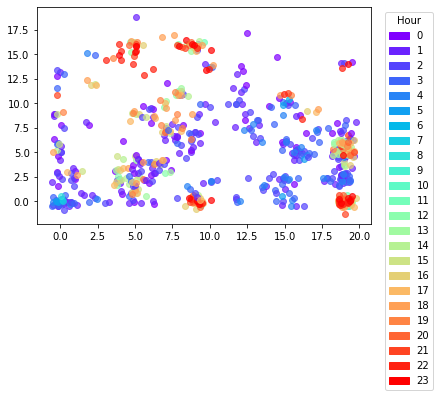

In [19]:
# https://matplotlib.org/tutorials/intermediate/legend_guide.html
# https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib
# https://www.programcreek.com/python/example/90948/matplotlib.cm.rainbow

colors = cm.rainbow(np.linspace(0, 1, 24))

for i in range(values_map.shape[0]):
  for j in range(values_map.shape[1]):
    for k in range(values_map.shape[2]):
      for nr_points in range(int(values_map[i,j,k])):
        plt.scatter(i + np.random.normal(0, 0.3), j + np.random.normal(0, 0.3), color=colors[k], alpha=0.7) #jitter


legend = np.empty(24, dtype=mpatches.Patch)
for i in range(24):
  patch = mpatches.Patch(color=colors[i], label=i)
  legend[i] = patch

plt.legend(legend, np.arange(24), bbox_to_anchor=(1.20, 1), title='Hour')
plt.show()

Analysis of data

Data limited to one hour span (22:00-23:00). 
Not limited in number of observations.

**Map A** is the arbitrary self-orgznizing map using colors for groups of locations that were estimated as physically close in the training process. It is actually the same data as in the previous plot, but not reduced in number of observations and using colors in a different way.

**Map B** uses pickup latitude and longitude data, so it shows real-life map of pickup spots in New York. The colors are the same as in Map A, so we can see that the locations that were estimated as close are indeed located within close area.

In [20]:
select_hour = df[(df.hour_pickup >= 22.0) & (df.hour_pickup < 23.0)]

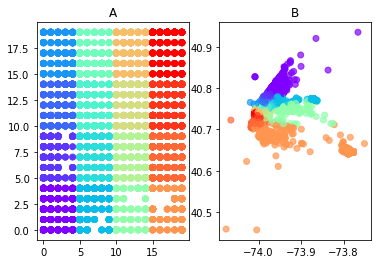

In [21]:
colors = cm.rainbow(np.linspace(0, 1, 16))
colors = colors.reshape(4, 4, 4)

fig, axs = plt.subplots(1,2)
axs[0].scatter(select_hour.winner_x, select_hour.winner_y, color=colors[select_hour.winner_x // 5, select_hour.winner_y // 5])
axs[0].set_title("A")
axs[1].scatter(select_hour.pickup_longitude, select_hour.pickup_latitude, color=colors[select_hour.winner_x // 5, select_hour.winner_y // 5], alpha=0.7)
axs[1].set_title("B")
# axs[1].set(xlabel="longitude", ylabel="latitude")
plt.show()

####Analysis 2/MiniSOM
**What are the typical pickup locations for each vendor?**


In [22]:
data = df_norm[['pickup_longitude', 'pickup_latitude']].to_numpy()
data_label = df.vendorid.astype('int8').to_numpy()

som = MiniSom(30, 30, data[0].shape[0], sigma=1, learning_rate=0.5)
som.pca_weights_init(data)
som.train_random(data, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.00011185521088830452


In [23]:
values_map = np.zeros((30, 30, 2))

for cnt,xx in enumerate(data):
  w = som.winner(xx) # getting the winner
  values_map[w[0], w[1], data_label[cnt]-1] += 1

values_map = values_map // 500

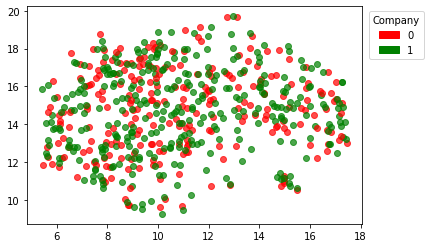

In [24]:
colors = ['r', 'g']

for i in range(values_map.shape[0]):
  for j in range(values_map.shape[1]):
    for k in range(values_map.shape[2]):
      for nr_points in range(int(values_map[i,j,k])):
        plt.scatter(i + np.random.normal(0, 0.3), j + np.random.normal(0, 0.3), color=colors[k], alpha=0.7) #jitter

# legend
legend = np.empty(2, dtype=mpatches.Patch)
for i in range(2):
  patch = mpatches.Patch(color=colors[i], label=i)
  legend[i] = patch

plt.legend(legend, np.arange(2), bbox_to_anchor=(1.20, 1), title='Company')
plt.show()

####Analysis 3/MiniSOM
**What is the division of payment types among otherwise uniform data?**

payment type (color) and vendor (marker) 
trip_distance, ratecodeid, total_amount

The color groups indicate two main payment types: 1 (credit card) and 2 (cash). The groups overlap in a certain area but also have separate regions. 
The configuration may indicate that one of payment types typically gets  smaller payment for a similar service in terms of (trip_distance, ratecodeid, total_amount). It is observable for both verdors. Need for statistical confirmation!


In [25]:
data = df_norm[['trip_distance', 'ratecodeid', 'total_amount']].to_numpy()
data_label = df.payment_type.astype('int8').to_numpy()
data_label_2 = df.vendorid.astype('int8').to_numpy()

som = MiniSom(30, 30, data[0].shape[0], sigma=1, learning_rate=0.5)
som.pca_weights_init(data)
som.train_random(data, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.001348724094559634


In [26]:
values_map = np.zeros((100, 100, 6, 2))

for cnt,xx in enumerate(data):
  w = som.winner(xx) # getting the winner
  values_map[w[0], w[1], data_label[cnt]-1, data_label_2[cnt]-1] += 1

values_map = values_map // 500

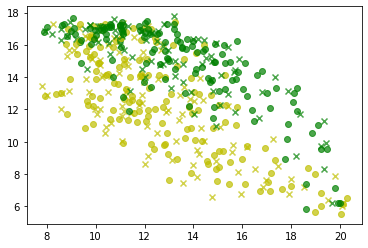

In [27]:
colors = ['y','g','b','r','b', 'violet']
markers = ['x', 'o']

for i in range(values_map.shape[0]):
  for j in range(values_map.shape[1]):
    for k in range(values_map.shape[2]):
      for l in range(values_map.shape[3]):
        for nr_points in range(int(values_map[i,j,k,l])):
          plt.scatter(i + np.random.normal(0, 0.3), j + np.random.normal(0, 0.3), color=colors[k], marker=markers[l], alpha=0.7) #jitter

## Empirical Verification
1 - credit card

2 - cash

other payment types do not have much representation and were omitted

Show histogram of payment values for each payment type separately, within small arbitrary ranges of distances, 1000 rows each payment type (just intuition)

Show histogram of payment values for each payment type. The histogram is limited to 150 000 entries per payment type. Visibly, credit card payments are larger than cash payments.

In [28]:
verification_data = df[['trip_distance', 'payment_type', 'total_amount']]
# verification_data = verification_data[(verification_data.trip_distance > 1.5) & (verification_data.trip_distance < 2.0)]
type1 = verification_data[verification_data.payment_type == 1.0]
type2 = verification_data[verification_data.payment_type == 2.0]
print("type1 count\n", type1.count(), "\ntype2 count\n", type2.count())

type1 count
 trip_distance    182340
payment_type     182340
total_amount     182340
dtype: int64 
type2 count
 trip_distance    155432
payment_type     155432
total_amount     155432
dtype: int64


[]

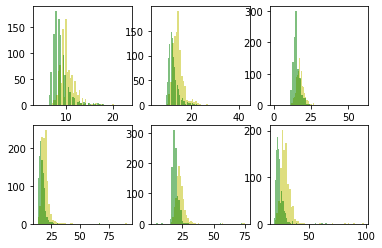

In [29]:
fig, axs = plt.subplots(2,3)
axs[0,0].hist(type1[(type1.trip_distance > 1.0) & (type1.trip_distance < 1.5)].total_amount.head(1000), alpha=0.5, bins=50, color='y')
axs[0,0].hist(type2[(type2.trip_distance > 1.0) & (type2.trip_distance < 1.5)].total_amount.head(1000), alpha=0.5, bins=50, color='g')
axs[0,1].hist(type1[(type1.trip_distance > 2.0) & (type1.trip_distance < 2.5)].total_amount.head(1000), alpha=0.5, bins=50, color='y')
axs[0,1].hist(type2[(type2.trip_distance > 2.0) & (type2.trip_distance < 2.5)].total_amount.head(1000), alpha=0.5, bins=50, color='g')
axs[0,2].hist(type1[(type1.trip_distance > 3.0) & (type1.trip_distance < 3.5)].total_amount.head(1000), alpha=0.5, bins=50, color='y')
axs[0,2].hist(type2[(type2.trip_distance > 3.0) & (type2.trip_distance < 3.5)].total_amount.head(1000), alpha=0.5, bins=50, color='g')
axs[1,0].hist(type1[(type1.trip_distance > 3.5) & (type1.trip_distance < 4.0)].total_amount.head(1000), alpha=0.5, bins=50, color='y')
axs[1,0].hist(type2[(type2.trip_distance > 3.5) & (type2.trip_distance < 4.0)].total_amount.head(1000), alpha=0.5, bins=50, color='g')
axs[1,1].hist(type1[(type1.trip_distance > 4.5) & (type1.trip_distance < 5.0)].total_amount.head(1000), alpha=0.5, bins=50, color='y')
axs[1,1].hist(type2[(type2.trip_distance > 4.5) & (type2.trip_distance < 5.0)].total_amount.head(1000), alpha=0.5, bins=50, color='g')
axs[1,2].hist(type1[(type1.trip_distance > 6.5) & (type1.trip_distance < 7.0)].total_amount.head(1000), alpha=0.5, bins=50, color='y')
axs[1,2].hist(type2[(type2.trip_distance > 6.5) & (type2.trip_distance < 7.0)].total_amount.head(1000), alpha=0.5, bins=50, color='g')
plt.plot()

[]

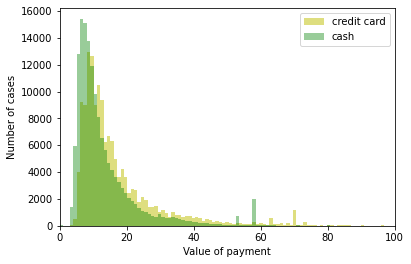

In [30]:
bins = np.linspace(0, 100, 100)
plt.hist(type1.total_amount.head(150000), alpha=0.5, bins=bins, color='y')
plt.hist(type2.total_amount.head(150000), alpha=0.4, bins=bins, color='g')
plt.xlabel("Value of payment")
plt.ylabel("Number of cases")
plt.legend(["credit card", "cash"])
plt.xlim(xmin=0, xmax=100)
plt.plot()

In [31]:
type1.total_amount.mean() # credit card

17.46100131620796

In [32]:
type2.total_amount.mean() # cash

13.470381131332104